In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D


print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.6.0


In [2]:
base_dir = "Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [3]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [4]:
#Performing Image Augmentation to have more data samples

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


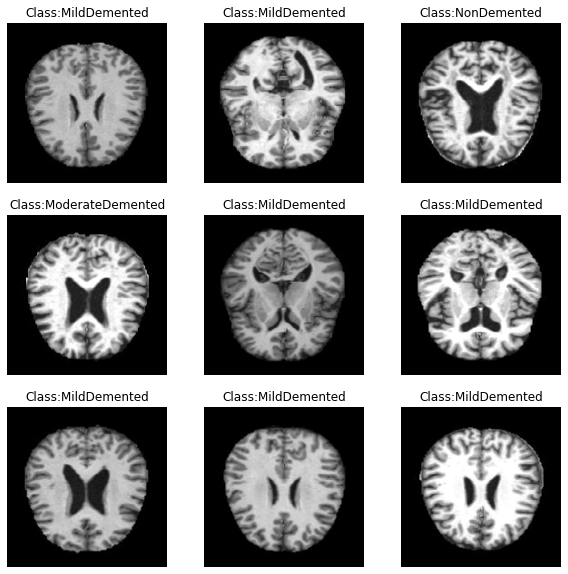

In [5]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [6]:
#Retrieving the data from the ImageDataGenerator iterator

train_data, train_labels = train_data_gen.next()

In [7]:
#Performing over-sampling of the data, since the classes are imbalanced

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


In [8]:
#Splitting the data into train, test, and validation sets

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [10]:
from tensorflow.keras.applications.vgg16 import VGG16

In [11]:
vgg16_model = VGG16(input_shape=(176,176,3), 
                   include_top=False,
                   weights="imagenet")

In [12]:
for layer in vgg16_model.layers:
    layer.trainable=False

In [13]:
#creating custom model using vgg16 

In [14]:
custom_vgg16_model = Sequential([
        vgg16_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ], name = "vgg16_cnn_model")

In [15]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

In [18]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback, rop_callback]
    
custom_vgg16_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

custom_vgg16_model.summary()

Model: "vgg16_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 512)         0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)           

In [20]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 50

history = custom_vgg16_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/50
256/256 [==============================] - 769s 3s/step - loss: 1.4317 - acc: 0.3978 - auc: 0.6611 - f1_score: 0.3948 - val_loss: 1.0955 - val_acc: 0.5068 - val_auc: 0.7876 - val_f1_score: 0.5076
Epoch 2/50
256/256 [==============================] - 758s 3s/step - loss: 0.9377 - acc: 0.5802 - auc: 0.8416 - f1_score: 0.5700 - val_loss: 0.6644 - val_acc: 0.6885 - val_auc: 0.9247 - val_f1_score: 0.6782
Epoch 3/50
256/256 [==============================] - 757s 3s/step - loss: 0.8056 - acc: 0.6403 - auc: 0.8834 - f1_score: 0.6340 - val_loss: 0.5946 - val_acc: 0.7109 - val_auc: 0.9334 - val_f1_score: 0.6943
Epoch 4/50
256/256 [==============================] - 780s 3s/step - loss: 0.7627 - acc: 0.6648 - auc: 0.8961 - f1_score: 0.6587 - val_loss: 0.5531 - val_acc: 0.7529 - val_auc: 0.9447 - val_f1_score: 0.7482
Epoch 5/50
256/256 [==============================] - 792s 3s/step - loss: 0.7310 - acc: 0.6824 - auc: 0.9051 - f1_score: 0.6805 - val_loss: 0.5354 - val_acc: 0.7661 - val_

256/256 [==============================] - 739s 3s/step - loss: 0.4007 - acc: 0.8501 - auc: 0.9713 - f1_score: 0.8492 - val_loss: 0.2566 - val_acc: 0.8989 - val_auc: 0.9882 - val_f1_score: 0.8978
Epoch 41/50
256/256 [==============================] - 741s 3s/step - loss: 0.4086 - acc: 0.8468 - auc: 0.9699 - f1_score: 0.8458 - val_loss: 0.2545 - val_acc: 0.9097 - val_auc: 0.9895 - val_f1_score: 0.9094
Epoch 42/50
256/256 [==============================] - 739s 3s/step - loss: 0.4051 - acc: 0.8472 - auc: 0.9704 - f1_score: 0.8465 - val_loss: 0.2495 - val_acc: 0.9077 - val_auc: 0.9891 - val_f1_score: 0.9068
Epoch 43/50
256/256 [==============================] - 741s 3s/step - loss: 0.3974 - acc: 0.8490 - auc: 0.9718 - f1_score: 0.8482 - val_loss: 0.2392 - val_acc: 0.9160 - val_auc: 0.9899 - val_f1_score: 0.9157
Epoch 44/50
256/256 [==============================] - 741s 3s/step - loss: 0.4024 - acc: 0.8508 - auc: 0.9711 - f1_score: 0.8499 - val_loss: 0.2466 - val_acc: 0.9160 - val_auc: 0.

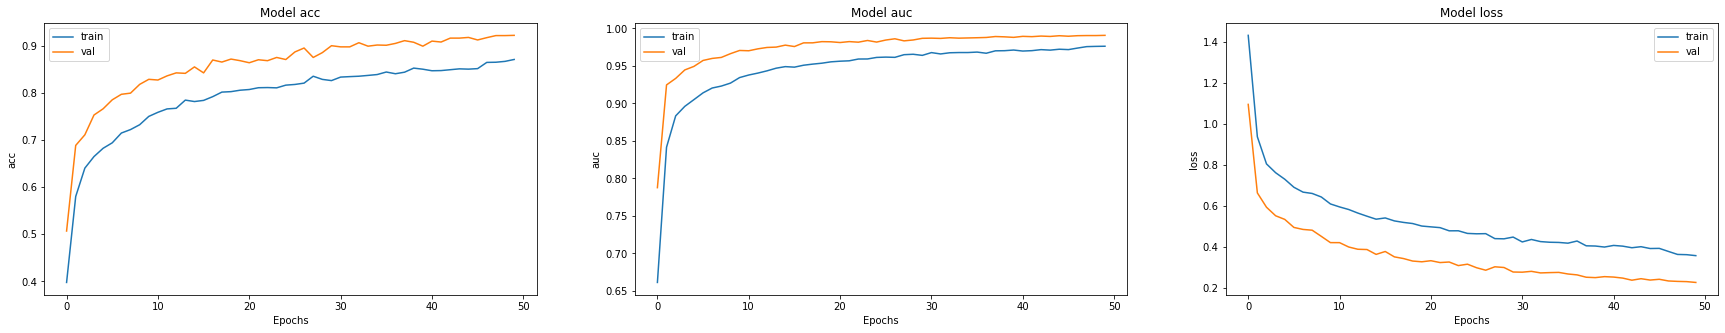

In [21]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [23]:
#Evaluating the model on the data

train_scores = custom_vgg16_model.evaluate(train_data, train_labels)
val_scores = custom_vgg16_model.evaluate(val_data, val_labels)
test_scores = custom_vgg16_model.evaluate(test_data, test_labels)

print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

80/80 [==============================] - 189s 2s/step - loss: 0.2203 - acc: 0.9262 - auc: 0.9922 - f1_score: 0.9264
Training Accuracy: 98.00%
Validation Accuracy: 92.19%
Testing Accuracy: 92.62%


In [24]:
#Predicting the test data

pred_labels = custom_vgg16_model.predict(test_data)

In [25]:
#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.95      0.95      0.95       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.90      0.86      0.88       662
ModerateDemented       0.86      0.89      0.87       624

       micro avg       0.93      0.93      0.93      2560
       macro avg       0.93      0.93      0.93      2560
    weighted avg       0.93      0.93      0.93      2560
     samples avg       0.93      0.93      0.93      2560



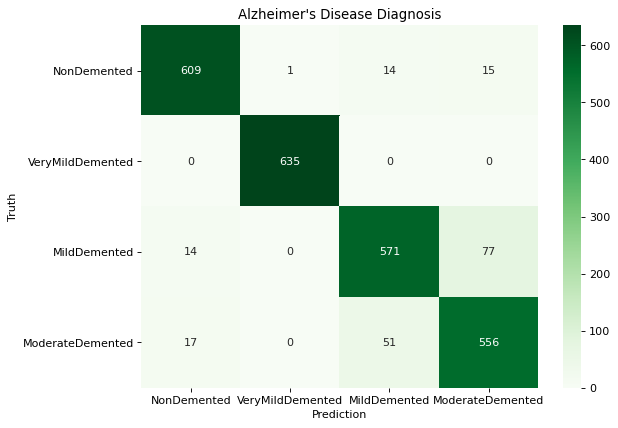

In [26]:
#Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [27]:
#Printing some other classification metrics

print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 92.67 %
Matthew's Correlation Coefficient: 90.17 %


In [30]:
#Saving the model for future use

custom_vgg16_model_dir = work_dir + "alzheimer_cnn_vgg16_model"
custom_vgg16_model.save(custom_vgg16_model_dir, save_format='h5')
os.listdir(work_dir)

['alzheimer_cnn_vgg16_model',
 'alzheimer_inception_vgg16_model',
 'MildDemented',
 'ModerateDemented',
 'NonDemented',
 'VeryMildDemented']

In [32]:
pretrained_model = tf.keras.models.load_model(custom_vgg16_model_dir)

#Check its architecture
plot_model(pretrained_model, to_file=work_dir + "model_plot.png", show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [33]:
pip install graphviz

In [34]:
pretrained_model = tf.keras.models.load_model(custom_vgg16_model_dir)

#Check its architecture
plot_model(pretrained_model, to_file=work_dir + "model_plot.png", show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [35]:
pip install pydot


Note: you may need to restart the kernel to use updated packages.


In [1]:
pretrained_model = tf.keras.models.load_model(custom_vgg16_model_dir)

#Check its architecture
plot_model(pretrained_model, to_file=work_dir + "model_plot.png", show_shapes=True, show_layer_names=True)

NameError: name 'tf' is not defined

In [2]:
import tensorflow as tf

In [3]:
pretrained_model = tf.keras.models.load_model(custom_vgg16_model_dir)

#Check its architecture
plot_model(pretrained_model, to_file=work_dir + "model_plot.png", show_shapes=True, show_layer_names=True)

NameError: name 'custom_vgg16_model_dir' is not defined